In [11]:
import numpy as np
import matplotlib.pyplot as plt

# custom libs
import pde_solver_lib as psl
from schemes import methods as METHODS
from tests import TEST_CASES

In [12]:



class HyperbolicModel:

    def __init__(self, equation, model) -> None:
        self.equation = equation
        self.model = model

    def getMesh(self) -> np.ndarray:
        minimum = self.equation.bounds.x.min
        maximum = self.equation.bounds.x.max
        nx = self.model.nx
        return np.linspace(minimum, maximum, nx)
    
    def iterate(self, uPred, dt, dx, scheme = None, method = None):

        # extention: [0, ...uPred, 0]
        uPredExt = np.zeros(len(uPred) + 2)
        uPredExt[1:-1] = uPred

        u = METHODS[scheme][method](uPredExt, dt, dx, self.equation.flux)

        # Neumann's conditions
        u[0] = u[1]
        u[-1] = u[-2]

        return u

    def approxFixedCFL(self, scheme, method) -> None: # type ?

        flux = self.equation.flux
        fluxPrime = flux.data["prime"]

        t0 = self.equation.bounds.t.min
        Tf = self.equation.bounds.t.max

        cfl = self.model.cfl
        
        x = self.getMesh()
        u = self.equation.initial(x)

        length = self.equation.bounds.x.getLength()
        dx = length / self.model.nx

		# variable 'dt' increment, constant CFL
        t = t0
        while t < Tf:
            L = np.max(np.abs(fluxPrime(u)))
            #print(L)
            dt = min(Tf, cfl * dx / L)
            u = self.iterate(u, dt, dx, scheme = scheme, method = method)
            t += dt

        return (x, u)
    
    def plot(self, ax, x, y, color = "black", label = None, title = None):
        """
        ax : matplotlib.axes._axes.Axes
        x, y : array-like
        """

        if ax == None :
            return
        
        ax.plot(x, y, color = color, label = label)

        deltaPlot = 0.1
        ax.set_xlim(self.equation.bounds.x.min - deltaPlot, self.equation.bounds.x.max + deltaPlot)

        ax.legend()
        
        if title:
            ax.set_title(title)



In [13]:
It = psl.Interval(2, 3)
I = psl.Interval(1, 7)
print(It, I)

B = psl.Bounds(It, I)
print(B)

print(It.getLength())



[2,3] [1,7]
[2,3]x[1,7]
1


In [14]:
def square(x):
    """Returns the square of a number."""
    return x * x

square_function = psl.Function(func=square, name="Square", data={"description": "Calculates the square of a number."})
usage_info = square_function(5)
usage_info

25

In [15]:
def square_half(x):
    """Returns the square of a number."""
    return x * x * 0.5

def identity(x):
    return x

f = psl.Function(func = square_half, name = "square_half", data = { "prime" : identity })
rp = psl.Function.indicator(psl.Interval(2, 3))

x = np.linspace(-1, 2, 4)

print(x, rp(x))


f.data["prime"](10)



[-1.  0.  1.  2.] [0. 0. 0. 1.]


10

In [16]:
he = psl.HyperbolicEquation(B, f, rp)

print(he.__doc__)
print(he)


    Represents a hyperbolic partial differential equation (PDE) of the form:
    du/dt + df(u)/dx = 0, for all (t,x) in a specified bounds, with an initial condition u(t0, x) = u0(x).
    
    This class is designed to encapsulate the components necessary to define and work with such an equation,
    including the spatial and temporal bounds, the flux function 'f', and the initial condition 'u0'.
    
    The PDE is defined over a domain with u: (R+, R) --> R and the flux function f: R --> R, allowing for the
    representation and manipulation of equations with real-valued solutions and inputs.

    Attributes:
        bounds (Bounds): The temporal and spatial bounds for the equation, specifying the domain as a product of two intervals.
        flux (Function): The flux function 'f' in the equation, encapsulated as a Function instance. This function should take a single real argument and return a real value.
        initial (Function): The initial condition 'u0', provided as a Functi

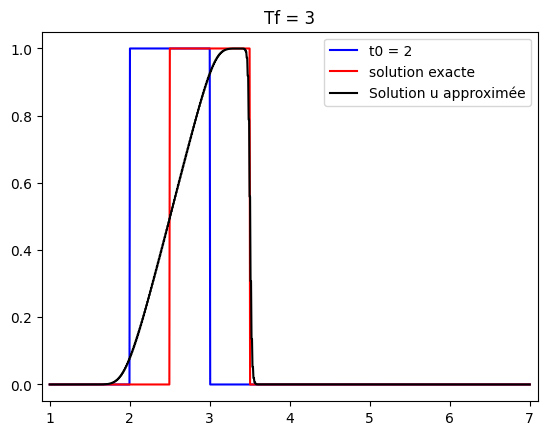

In [17]:
hm = HyperbolicModel(
    equation = psl.HyperbolicEquation(B, f, rp),
    model = psl.Model(nx = 1000, nt = 100, cfl = 0.5)
)

x, u = hm.approxFixedCFL("LaxFriedrich", "FiniteDifferences")
u0 = hm.equation.initial(x)
u1 = hm.equation.initial(x - 0.5)

fig, ax = plt.subplots()
hm.plot(ax, x, u0, label = f"t0 = {hm.equation.bounds.t.min}", color="blue")
hm.plot(ax, x, u1, label = f"solution exacte", color="red")
hm.plot(ax, x, u, label = "Solution u approximée", title = f"Tf = {hm.equation.bounds.t.max}")
plt.show()


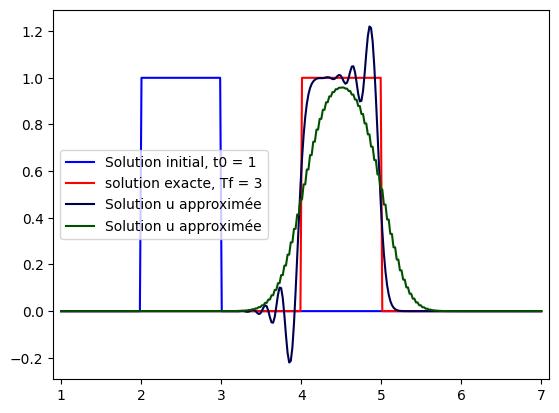

In [18]:
hm = HyperbolicModel(
    equation = TEST_CASES["debug"],
    model = psl.Model(nx = 300, nt = 100, cfl = 0.5)
)

timePassed = hm.equation.bounds.t.getLength()

x, ufv = hm.approxFixedCFL("LaxFriedrich", "FiniteVolumes")
_, ufd = hm.approxFixedCFL("LaxFriedrich", "FiniteDifferences")
u0 = hm.equation.initial(x)
uex = hm.equation.exact(timePassed, x)

fig, ax = plt.subplots()
hm.plot(ax, x, u0, label = f"Solution initial, t0 = {hm.equation.bounds.t.min}", color="blue")
hm.plot(ax, x, uex, label = f"solution exacte, Tf = {hm.equation.bounds.t.max}", color="red")
hm.plot(ax, x, ufv, label = f"Solution u approximée", color = "#000050")
hm.plot(ax, x, ufd, label = f"Solution u approximée", color = "#005000")
plt.show()



log(err)/log(dx) : -0.5791956065629278
log(err)/log(dx) : 0.24717233520824033
log(err)/log(dx) : 0.4342919640761008
log(err)/log(dx) : 0.42782529869016817
log(err)/log(dx) : 0.46512545401708133
log(err)/log(dx) : 0.48514455376860066
log(err)/log(dx) : 0.49855435970504663
log(err)/log(dx) : 0.5122139348216247
log(err)/log(dx) : 0.5187088468264973
log(err)/log(dx) : 0.5280379116760211


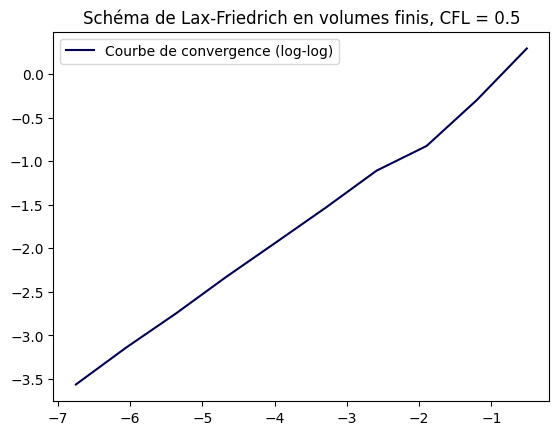

pente = 0.6187038014148774


In [19]:
hm = HyperbolicModel(
    equation = TEST_CASES["debug"],
    model = psl.Model(nx = 10, nt = 100, cfl = 0.5)
)

timePassed = hm.equation.bounds.t.getLength()
length = hm.equation.bounds.x.getLength()

spaceSteps = []
errs = []



for _ in range(10):
    x, ufd = hm.approxFixedCFL("LaxFriedrich", "FiniteDifferences")
    uex = hm.equation.exact(timePassed, x)

    err = np.abs(ufd - uex).sum() / np.abs(uex).sum()
    dx = length / hm.model.nx
    #print(f"Erreur de Convergence : {err}")
    #print(f"log(err) : {np.log(err)}")

    spaceSteps.append(dx)
    errs.append(err)

    print(f"log(err)/log(dx) : {np.log(err) / np.log(dx)}")

    hm.model.multiplySpaceStep(2)

X = np.log(spaceSteps)
Y = np.log(errs)
plt.plot(X, Y, color = "#000050", label = "Courbe de convergence (log-log)")
plt.legend()
plt.title("Schéma de Lax-Friedrich en différences finies, CFL = 0.5")
plt.show()

slope = (Y[-1] - Y[0]) / (X[-1] - X[0])
print(f"pente = {slope}")

HyperbolicEquation:
	du/dt + df(u)/dx = 0, where f = Function:linear1(.), (t,x) in [0,1]x[-2,5]
	u(t0, x) = u0(x), where u0 = Function:indicator(.)


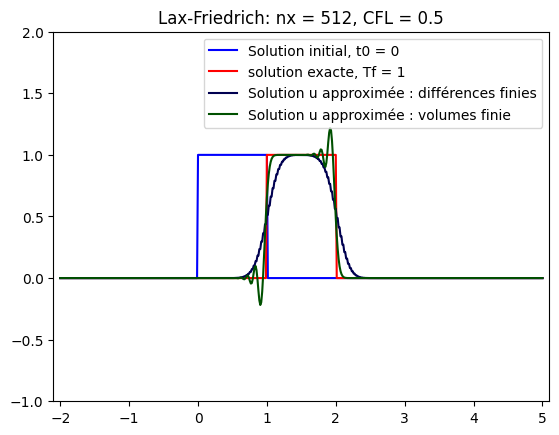

HyperbolicEquation:
	du/dt + df(u)/dx = 0, where f = Function:linear1(.), (t,x) in [0,1]x[-2,5]
	u(t0, x) = u0(x), where u0 = Function:changingStep(.)


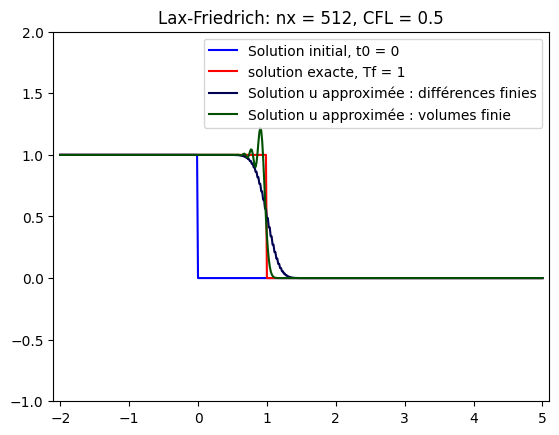

HyperbolicEquation:
	du/dt + df(u)/dx = 0, where f = Function:linear1(.), (t,x) in [0,1]x[-2,5]
	u(t0, x) = u0(x), where u0 = Function:sawTooth(.)


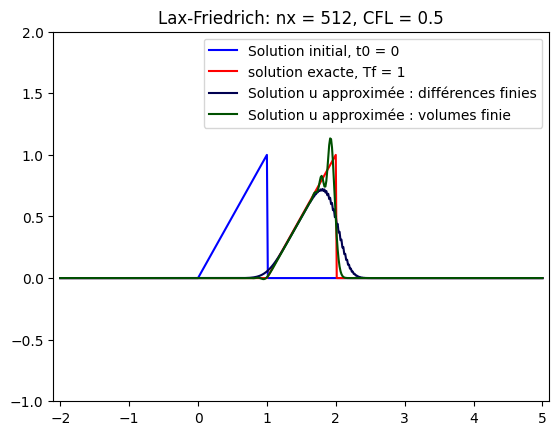

HyperbolicEquation:
	du/dt + df(u)/dx = 0, where f = Function:linear1(.), (t,x) in [0,1]x[-2,5]
	u(t0, x) = u0(x), where u0 = Function:triangle(.)


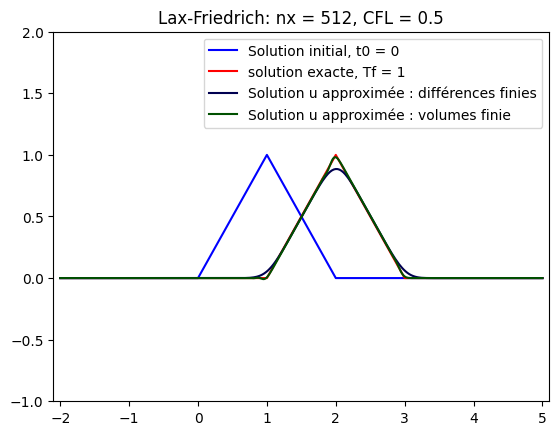

HyperbolicEquation:
	du/dt + df(u)/dx = 0, where f = Function:linear2(.), (t,x) in [0,1]x[-2,5]
	u(t0, x) = u0(x), where u0 = Function:indicator(.)


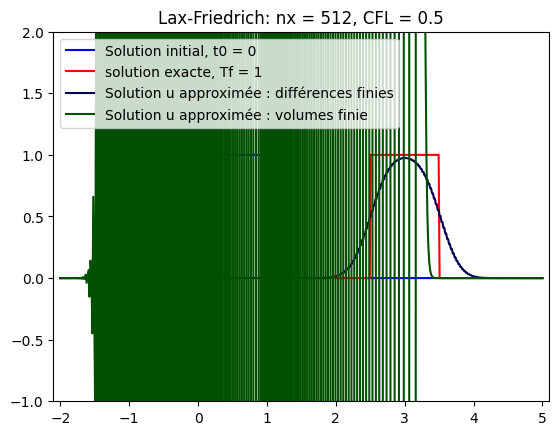

HyperbolicEquation:
	du/dt + df(u)/dx = 0, where f = Function:linear2(.), (t,x) in [0,1]x[-2,5]
	u(t0, x) = u0(x), where u0 = Function:changingStep(.)


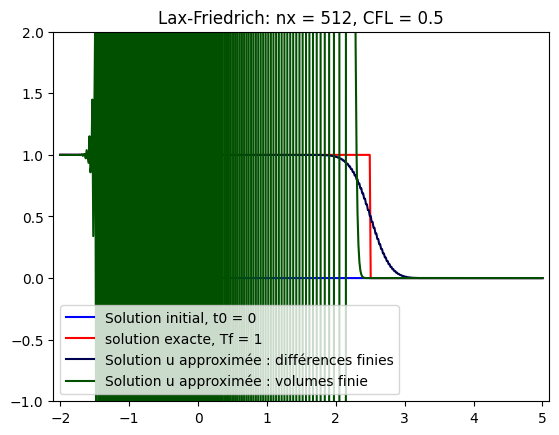

HyperbolicEquation:
	du/dt + df(u)/dx = 0, where f = Function:linear2(.), (t,x) in [0,1]x[-2,5]
	u(t0, x) = u0(x), where u0 = Function:sawTooth(.)


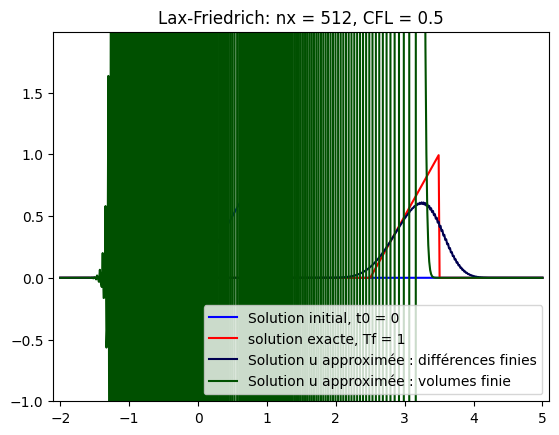

HyperbolicEquation:
	du/dt + df(u)/dx = 0, where f = Function:linear2(.), (t,x) in [0,1]x[-2,5]
	u(t0, x) = u0(x), where u0 = Function:triangle(.)


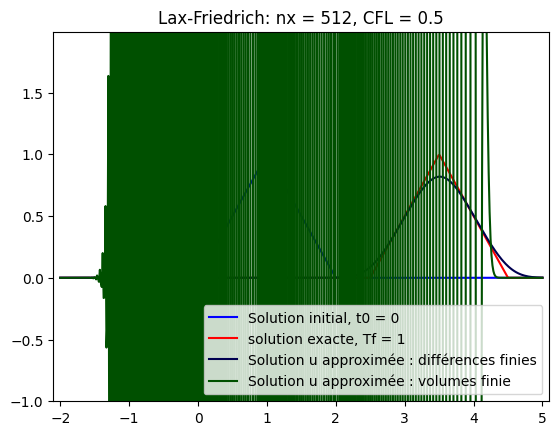

In [20]:



def showTestCase(testName, nx = 512):

    # equation and model
    he = TEST_CASES[testName]

    print(he)

    hm = HyperbolicModel(
        equation = he,
        model = psl.Model(nx = nx, nt = None, cfl = 0.5)
    )

    # time between t0 and tf
    timePassed = hm.equation.bounds.t.getLength()

    # exact and approximation
    x, ulffd = hm.approxFixedCFL("LaxFriedrich", "FiniteDifferences")
    _, ulffv = hm.approxFixedCFL("LaxFriedrich", "FiniteVolumes")
    u0 = hm.equation.initial(x)
    uex = hm.equation.exact(timePassed, x)

    # plotting
    fig, ax = plt.subplots()
    hm.plot(ax, x, u0, label = f"Solution initial, t0 = {hm.equation.bounds.t.min}", color="blue")
    hm.plot(ax, x, uex, label = f"solution exacte, Tf = {hm.equation.bounds.t.max}", color="red")
    hm.plot(ax, x, ulffd, label = f"Solution u approximée : différences finies", color = "#000050")
    hm.plot(ax, x, ulffv, label = f"Solution u approximée : volumes finie", color = "#005000")
    ax.set_title(f"Lax-Friedrich: nx = {hm.model.nx}, CFL = {hm.model.cfl}")

    # rescale y
    maximum = np.max(uex)
    minimum = np.min(uex)
    delta = 1.0

    ax.set_ylim(minimum - delta, maximum + delta)

    # show
    plt.show()



showTestCase("linear_ind01")
showTestCase("linear_step10_0")
showTestCase("linear_sawTooth01")
showTestCase("linear_triangle012")

showTestCase("linear5_2_ind01")
showTestCase("linear5_2_step10_0")
showTestCase("linear5_2_sawTooth01")
showTestCase("linear5_2_triangle012")